In [1]:
%cd ../..

c:\Users\aldion\Desktop\Development\taxi-fare-predictor


In [2]:
import pandas as pd
from src.utils.models import build_baseline_model, build_preprocessing_layer_model
from src.utils.load_data import load_dataset, NNMode
import tensorflow as tf
from src.utils.plot_manager import plot_history

### Loading the datasets

In [3]:
TRAIN_DATA = "data/taxi-train.csv"
VALID_DATA = "data/taxi-valid.csv"
TEST_DATA = "data/taxi-test.csv"

In [4]:
train_df = pd.read_csv(TRAIN_DATA)
valid_df = pd.read_csv(VALID_DATA)
test_df = pd.read_csv(TEST_DATA)
train_df.head()

,fare_amount,passenger_count,pickup_longitude,pickup_latitude,dropoff_longitude,dropoff_latitude,hourofday,dayofweek
0,8.1,1,-73.973731,40.791910,-73.962737,40.767318,14,4
1,4.5,2,-73.986495,40.739278,-73.986083,40.730933,10,6
2,2.9,1,-73.956043,40.772026,-73.956245,40.773934,22,3
3,7.0,1,-74.006557,40.705797,-73.980017,40.713617,6,3
4,6.5,1,-73.986443,40.741612,-73.990215,40.746467,10,2


In [5]:
NUM_TRAIN_EXAMPLES = train_df.shape[0]
NUM_EVAL_EXAMPLES = valid_df.shape[0]
NUM_TEST_EXAMPLES = test_df.shape[0]

In [6]:
TRAIN_DATASET = load_dataset(TRAIN_DATA, batch_size=32, mode=NNMode.TRAIN)
VALIDATION_DATASET = load_dataset(VALID_DATA, 1000, NNMode.EVAL).take(NUM_EVAL_EXAMPLES // 1000)
TEST_DATASET = load_dataset(TEST_DATA, 1000, NNMode.EVAL).take(NUM_TEST_EXAMPLES // 1000)


### Baseline Model 

In [7]:
baseline_model = build_baseline_model()

In [8]:
baseline_model.summary()

Model: "model"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 pickup_longitude (InputLayer)  [(None, 1)]          0           []                               
                                                                                                  
 pickup_latitude (InputLayer)   [(None, 1)]          0           []                               
                                                                                                  
 dropoff_longitude (InputLayer)  [(None, 1)]         0           []                               
                                                                                                  
 dropoff_latitude (InputLayer)  [(None, 1)]          0           []                               
                                                                                              

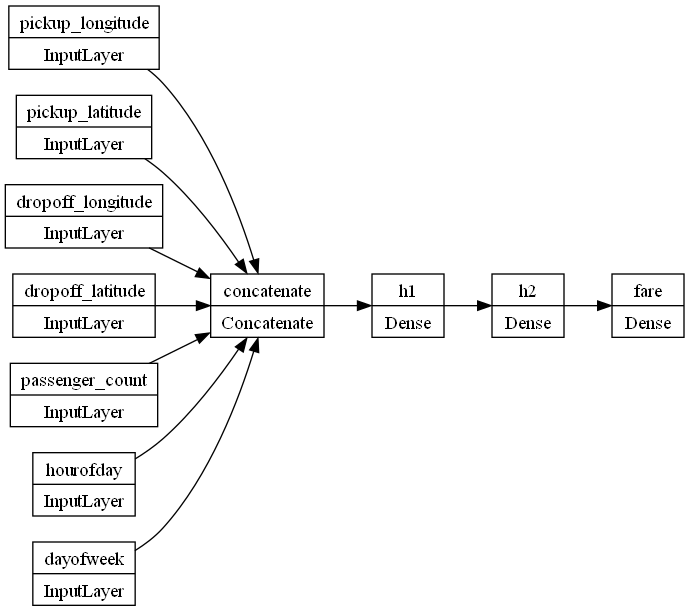

In [9]:
tf.keras.utils.plot_model(baseline_model, 'outputs/baseline_model.png', show_shapes=False, rankdir='LR')

### Baseline Model Training

In [10]:
BATCH_SIZE = 32
TRAIN_STEPS = NUM_TRAIN_EXAMPLES / BATCH_SIZE
EPOCHS = 20

In [11]:
baseline_history = baseline_model.fit(TRAIN_DATASET,
                    validation_data=VALIDATION_DATASET, steps_per_epoch=TRAIN_STEPS,
                    epochs=EPOCHS)


Epoch 1/20
1863/1863 [==============================] - 4s 2ms/step - loss: 102.2379 - rmse: 10.1113 - val_loss: 99.8566 - val_rmse: 9.9928
Epoch 2/20
1863/1863 [==============================] - 3s 2ms/step - loss: 103.8907 - rmse: 10.1927 - val_loss: 100.0455 - val_rmse: 10.0023
Epoch 3/20
1863/1863 [==============================] - 3s 2ms/step - loss: 101.5945 - rmse: 10.0794 - val_loss: 99.2594 - val_rmse: 9.9629
Epoch 4/20
1863/1863 [==============================] - 3s 2ms/step - loss: 102.5584 - rmse: 10.1271 - val_loss: 101.5403 - val_rmse: 10.0767
Epoch 5/20
1863/1863 [==============================] - 3s 2ms/step - loss: 101.2941 - rmse: 10.0645 - val_loss: 97.9469 - val_rmse: 9.8968
Epoch 6/20
1863/1863 [==============================] - 3s 2ms/step - loss: 103.9687 - rmse: 10.1965 - val_loss: 99.9732 - val_rmse: 9.9987
Epoch 7/20
1863/1863 [==============================] - 3s 2ms/step - loss: 100.7595 - rmse: 10.0379 - val_loss: 100.0796 - val_rmse: 10.0040
Epoch 8/20
186

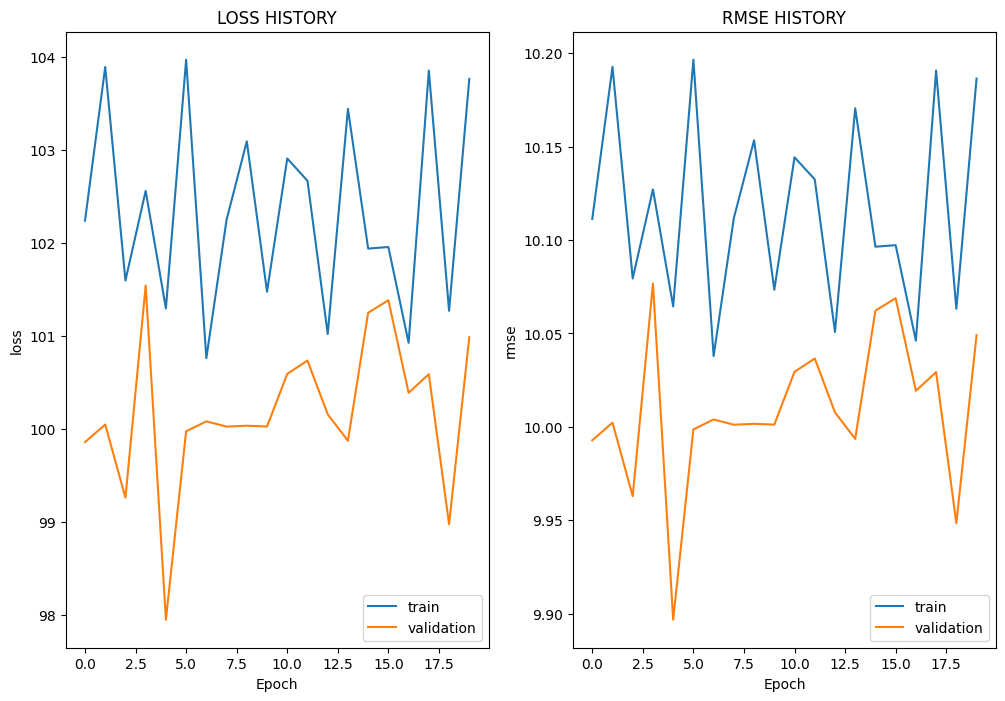

In [12]:
plot_history(baseline_history.history, metrics=["loss", "rmse"])

### Baseline Model Evaluation

In [13]:
baseline_model.evaluate(TEST_DATASET)

18/18 [==============================] - 0s 12ms/step - loss: 102.7500 - rmse: 10.1366


[102.75003814697266, 10.136569023132324]

In [14]:
TAXI_RIDE_DATA = {
    'pickup_longitude': tf.convert_to_tensor([-73.982683]),
    'pickup_latitude': tf.convert_to_tensor([40.742104]),
    'dropoff_longitude': tf.convert_to_tensor([-73.983766]),
    'dropoff_latitude': tf.convert_to_tensor([40.755174]),
    'passenger_count': tf.convert_to_tensor([3.0]),
    'hourofday': tf.convert_to_tensor([3.0]),
    'dayofweek': tf.convert_to_tensor([3.0]),
}

TAXI_RIDE_DATA


{'pickup_longitude': <tf.Tensor: shape=(1,), dtype=float32, numpy=array([-73.98268], dtype=float32)>,
 'pickup_latitude': <tf.Tensor: shape=(1,), dtype=float32, numpy=array([40.742104], dtype=float32)>,
 'dropoff_longitude': <tf.Tensor: shape=(1,), dtype=float32, numpy=array([-73.983765], dtype=float32)>,
 'dropoff_latitude': <tf.Tensor: shape=(1,), dtype=float32, numpy=array([40.755173], dtype=float32)>,
 'passenger_count': <tf.Tensor: shape=(1,), dtype=float32, numpy=array([3.], dtype=float32)>,
 'hourofday': <tf.Tensor: shape=(1,), dtype=float32, numpy=array([3.], dtype=float32)>,
 'dayofweek': <tf.Tensor: shape=(1,), dtype=float32, numpy=array([3.], dtype=float32)>}

In [15]:
prediction = baseline_model.predict(TAXI_RIDE_DATA, steps=1)
print(f"Predicted fare: {float(prediction):.2f} USD")

1/1 [==============================] - 0s 113ms/step
Predicted fare: 11.34 USD


#### Engineered Model

In [16]:
engineered_model = build_preprocessing_layer_model()

In [17]:
engineered_model.summary()

Model: "model_1"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 pickup_longitude (InputLayer)  [(None, 1)]          0           []                               
                                                                                                  
 pickup_latitude (InputLayer)   [(None, 1)]          0           []                               
                                                                                                  
 dropoff_longitude (InputLayer)  [(None, 1)]         0           []                               
                                                                                                  
 dropoff_latitude (InputLayer)  [(None, 1)]          0           []                               
                                                                                            

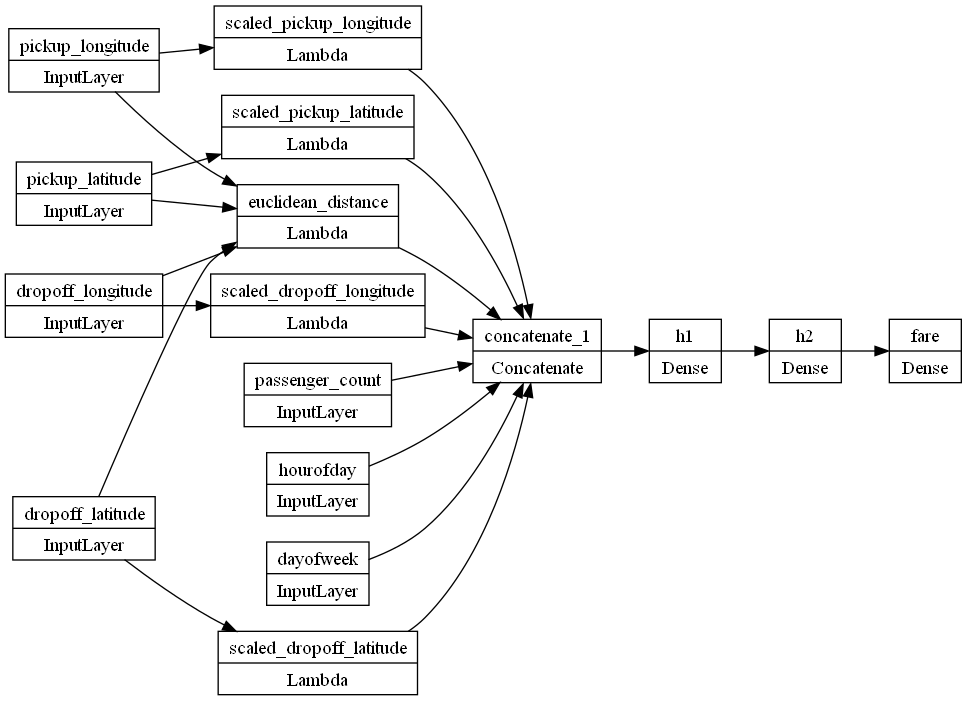

In [18]:
tf.keras.utils.plot_model(engineered_model, "outputs/engineered_model.png", show_shapes=False, rankdir='LR')

In [20]:
history = engineered_model.fit(TRAIN_DATASET,
                    validation_data=VALIDATION_DATASET, steps_per_epoch=TRAIN_STEPS,
                    epochs=20)

Epoch 1/20
582/582 [==============================] - 9s 12ms/step - loss: 125.2114 - rmse: 11.1898 - mse: 125.2114 - val_loss: 100.5042 - val_rmse: 10.0252 - val_mse: 100.5042
Epoch 2/20
582/582 [==============================] - 7s 12ms/step - loss: 96.5760 - rmse: 9.8273 - mse: 96.5760 - val_loss: 94.6988 - val_rmse: 9.7313 - val_mse: 94.6988
Epoch 3/20
582/582 [==============================] - 8s 13ms/step - loss: 93.2747 - rmse: 9.6579 - mse: 93.2747 - val_loss: 87.9028 - val_rmse: 9.3756 - val_mse: 87.9028
Epoch 4/20
582/582 [==============================] - 7s 12ms/step - loss: 80.2297 - rmse: 8.9571 - mse: 80.2297 - val_loss: 72.6064 - val_rmse: 8.5209 - val_mse: 72.6064
Epoch 5/20
582/582 [==============================] - 7s 12ms/step - loss: 57.4425 - rmse: 7.5791 - mse: 57.4425 - val_loss: 45.1879 - val_rmse: 6.7222 - val_mse: 45.1879
Epoch 6/20
582/582 [==============================] - 7s 12ms/step - loss: 32.6554 - rmse: 5.7145 - mse: 32.6554 - val_loss: 35.1892 - val_

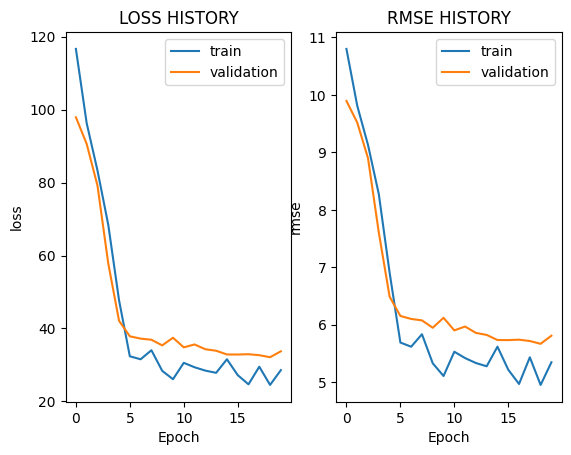

In [22]:
plot_history(history.history, metrics=["loss", "rmse"])

In [24]:
prediction = engineered_model.predict(TAXI_RIDE_DATA)
prediction

1/1 [==============================] - 0s 26ms/step


array([[8.407127]], dtype=float32)

In [25]:
print(f"Predicted fare: {float(prediction):.2f} USD")

Predicted fare: 8.41 USD
